In [1]:
%matplotlib notebook

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
import pandas as pd

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [3]:
### ASTEP data import ###
data = pd.read_csv("betapic_astep_2017.csv")
data = data.drop(data[data["FLAG"]==0].index)
# time = data[:,0][(1472<data[:,0])&(data[:,0]<1473)]
# # à prendre vers 1472
# flux = data[:,1][(1472<data[:,0])&(data[:,0]<1473)]
# flux = (flux - np.mean(flux))/(np.max(flux) - np.mean(flux))
# #flux /= np.median(flux)
# fig = plt.figure(figsize=(9,3))
# ax = plt.gca()
# #ax.scatter(time,flux,c="r",s=1)
# ax.plot(time,flux,c="r")
# ax.set_xlabel("Time")
# ax.set_ylabel("Relative Flux")
# fig.show()
print(data)

                 BJD     FCAL0     FCAL1     FCAL2     FCAL3  SUNELEV  \
0       57828.033191  0.999368  0.997744  0.997744  0.986043  -8.2478   
1       57828.034532  0.999062  0.997438  0.997438  0.985741  -8.3393   
2       57828.035872  0.999055  0.997431  0.997431  0.985734  -8.4301   
3       57828.037204  0.995737  0.994119  0.994119  0.982460  -8.5194   
4       57828.038529  0.995420  0.993802  0.993802  0.982147  -8.6075   
...              ...       ...       ...       ...       ...      ...   
106495  58022.320816  0.982556  0.995286  1.000116  0.995286  -6.0849   
106496  58022.321666  0.982197  0.994922  0.999751  0.994922  -6.0151   
106497  58022.322514  0.980829  0.993536  0.998358  0.993536  -5.9457   
106498  58022.323292  0.977350  0.990012  0.994816  0.990012  -5.8819   
106499  58022.323989  0.975282  0.987918  0.992712  0.987918  -5.8245   

        AIRMASS      SKY  FLAG  
0        1.1461   5319.0   1.0  
1        1.1473   4837.0   1.0  
2        1.1485   4401.0

In [4]:
freqs,amps,phases = np.loadtxt("TESS_freqs.txt",usecols=(1,2,3)).T
freqs_errors,amps_errors,phases_errors = np.loadtxt("TESS_freqs_errors.txt",usecols=(0,1,2)).T
data['BJD'].values

array([57828.0331912, 57828.0345319, 57828.0358721, ..., 58022.3225141,
       58022.3232916, 58022.323989 ])

In [5]:
# y = []
# y_error = []
# for i in time:
#     tmp = [] #saves one sine
#     tmp_error = []
#     for freq, amp, phase,freq_error,amp_error,phase_error in zip(freqs, amps, phases,freqs_errors, amps_errors, phases_errors):
# #    for freq_error,amp_error,phase_error in zip(freqs_errors, amps_errors, phases_errors):
#         tmp.append(amp * np.sin(2 * np.pi * freq * i + phase * 2 * np.pi))
#         tmp_error.append((amp+amp_error) * np.sin(2 * np.pi * (freq+freq_error) * i + (phase+phase_error) * 2 * np.pi))
#     y.append(np.sum(tmp))
#     y_error.append(np.sum(tmp_error))
# y = np.array(y)
# flux_error = np.array(y_error)

# y = (y - np.mean(y))/(np.max(y) - np.mean(y))
# flux_error = (flux_error - np.mean(flux_error))/(np.max(flux_error) - np.mean(flux_error))
# flux_error = y - flux_error

In [6]:
plt.figure(figsize=(9,3))
plt.plot(data["BJD"].values,data["FCAL0"].values)
plt.show()
time = data["BJD"].loc[(data["BJD"] > 57860) & (data["BJD"] < 57860.4)].values
flux = data["FCAL0"].loc[(data["BJD"] > 57860) & (data["BJD"] < 57860.4)].values
flux = (flux - np.mean(flux))/(np.max(flux) - np.mean(flux))

<IPython.core.display.Javascript object>

In [7]:
### GP Model ###
bounds = dict(log_S0= (-20,10), log_Q = (-10,10), log_omega0 = (4,6))
#kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
kernel = terms.SHOTerm(log_S0=1., log_Q=2.5, log_omega0=5.69,bounds=bounds)

gp = celerite.GP(kernel,mean=0.0)
gp.compute(time,yerr=0.1*flux)

print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -1001.5165633584473
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.69)])



In [8]:
x = np.linspace(np.min(time),np.max(time),15000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

In [9]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.show()

<IPython.core.display.Javascript object>

In [10]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

      fun: 69.92753717508282
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 18.35088028,  86.04968684, 220.45673518])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 176
      nit: 6
   status: 0
  success: True
        x: array([-3.00799549,  0.27625437,  5.27415429])
Final log-likelihood: -69.92753717508282
[4.93905837e-02 1.31818313e+00 1.95225302e+02]
Parameters: OrderedDict([('kernel:log_S0', -3.0079954865972787), ('kernel:log_Q', 0.2762543709120973), ('kernel:log_omega0', 5.274154296977578)])


In [11]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)
P = 2*np.pi/np.exp(results.x[2])*60*24
P

46.345359669832995

In [12]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("MAP Parameters GP fit")
plt.show()
# plt.scatter(x,flux - pred_mean,c='k',s=1)
# plt.axhline(y=0,color='k')
# plt.title("Residuals")
# plt.show()

<IPython.core.display.Javascript object>

In [13]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

In [14]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-20 < params[0] < 10) and (-10 < params[1] < 10) and (4 < params[2] < 6)) :
        return 0
    return -np.inf

In [15]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

In [16]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000,progress=True)
print("Finished")

  1%|          | 4/500 [00:00<00:15, 33.06it/s]

Running burn-in...


  0%|          | 3/5000 [00:00<03:06, 26.78it/s]

Running production...


100%|██████████| 5000/5000 [02:16<00:00, 36.63it/s]

Finished


In [17]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', -3.1284446014834764), ('kernel:log_Q', -2.8576440622051225), ('kernel:log_omega0', 5.661517166734801)])
Final MCMC log likelihood: 144.95491947083497


In [18]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.plot(time,flux,c="r")
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("Flux")
plt.ylim(np.min(flux),np.max(flux))
plt.title("GP fit after MCMC run")
plt.show()

<IPython.core.display.Javascript object>

In [19]:
w = np.exp(gp.get_parameter_vector())
print(w)
f = w[2]/(2*np.pi)
f

[4.37858488e-02 5.74038410e-02 2.87584626e+02]


45.770514716747996

In [20]:
P = 1/f
P*24*60

31.46130230152483

In [21]:
# x = np.linspace(1472,1480,10000)
# time = data[:,0][(1472<data[:,0])&(data[:,0]<1480)]
# flux = data[:,1][(1472<data[:,0])&(data[:,0]<1480)]
# flux = (flux - np.mean(flux))/(np.max(flux) - np.mean(flux))
# gp.compute(time,yerr=0.1*flux)
# pred_mean, pred_var = gp.predict(flux, x, return_var=True)
# pred_std = np.sqrt(pred_var)

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [ ]:
# color = "#ff7f0e"
# plt.figure(figsize=(9,3))
# plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
# plt.plot(x, pred_mean, color=color)
# plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
# plt.xlabel("x")
# plt.ylabel("y")
# plt.ylim(np.min(flux),np.max(flux))
# plt.title("MAP Parameters GP fit")
# plt.show()

<IPython.core.display.Javascript object>


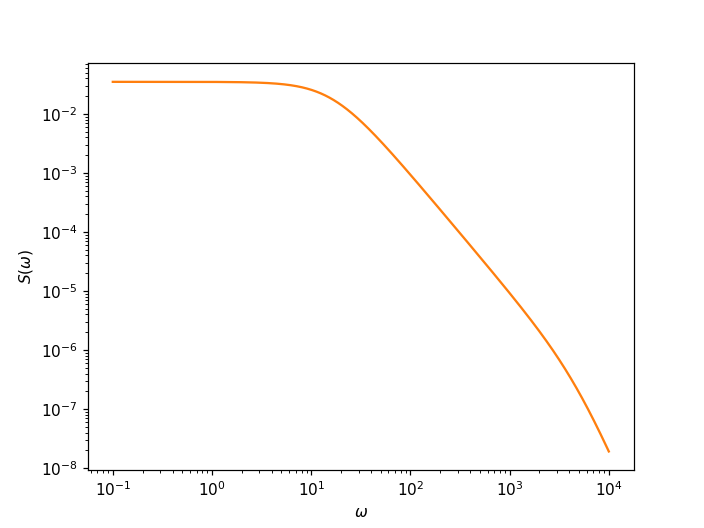

In [22]:
plt.figure()
omega = np.exp(np.linspace(np.log(0.1), np.log(10000), 5000))
psd = gp.kernel.get_psd(omega)
plt.plot(omega, psd, color=color)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$")
plt.show()

(41728, 3)


<IPython.core.display.Javascript object>


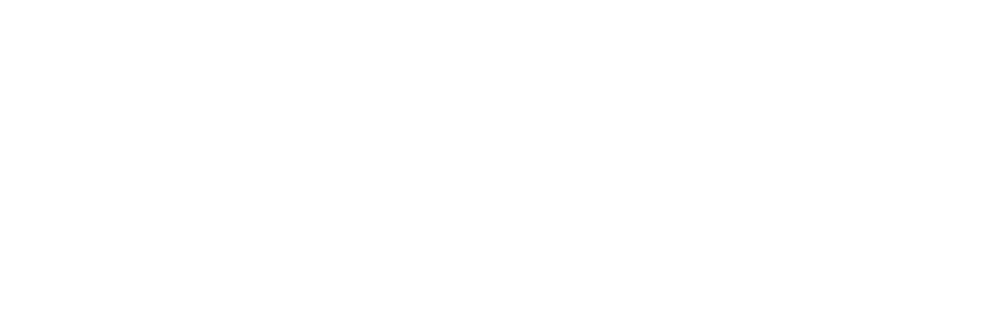

<IPython.core.display.Javascript object>


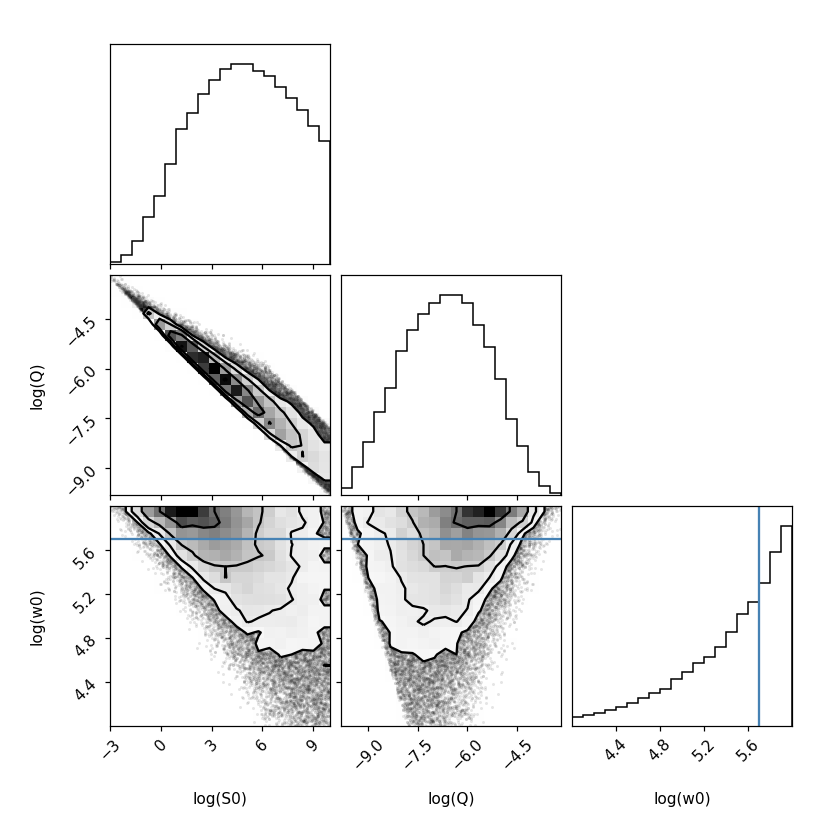

In [23]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
labels = ["log(S0)","log(Q)","log(w0)"]
plt.figure(figsize=(9,3))
fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4)])
plt.show()

In [24]:
tau = sampler.get_autocorr_time()
print(tau)

[49.55206934 48.3163532  51.72998902]
